## To save the final results of the behavior for each single animal (LATE Lesion)

In [3]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import time
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf

root='/data'
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
%run UtilityTools.ipynb

param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

In [4]:
def plot_batch_traj(root='/data', axes=None, columnNb=5, animal='Rat043', profile={}, sessionNb=5, stop_date=''):
    
    assert type(animal) == str, "enter the name of a single animal"
    if sessionNb>0:
        sessionList=batch_get_session_list(root,animalList=[animal],profile=profile,until_date=stop_date)['Sessions'][:sessionNb]
    else:
        sessionList=batch_get_session_list(root,animalList=[animal],profile=profile,until_date=stop_date)['Sessions'][sessionNb:]
        
    if sessionList:
        if axes is None:
            fig=plt.figure(figsize=(10,12),dpi=150,tight_layout=False)
#             fig.suptitle(animal,y=.92)
            rowNb=(len(sessionList)//columnNb)
            axes=[fig.add_subplot(rowNb,columnNb,i+1) for i,_ in enumerate(sessionList)]
            fig.tight_layout()
    for i,ax in enumerate(axes):
        try:
            data=Data(root,sessionList[i][:6],sessionList[i],redoPreprocess=False)
            plot_positions(data,onlyGood=False,raw=False,vSpan=False,axis=ax,linewidth=.5)
            ax.set_title('Session '+str(i+1))
            ax.set_axis_off()
        except Exception as e:
            print(repr(e))            
    
    return sessionList

### parameters

In [5]:
if "__file__" not in dir():
    animal='Rat225'
    
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-AfterBreak']
             }
    
    profile3={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Late-Lesion_DS']
             }

    
    TaskParamToPlot=["% good trials on last 40","percentile entrance time","standard deviation of entrance time",
        "Forward Speed Vs TreadmillSpeed","Tortuosity"]
    #Must have <5 params

    
    maxNbDays=10
    sessionNb=10
    sessionNbAfterBreak=7
    columnNb=5
    rowNb=2
    histoFileName=[]
    histoFileType=['.tif','.tiff','.jpg','.jpeg',".png"]
    n_iteration=1e3
    stop_dayPlot =maxNbDays
    fullLegend=False
    gridX=gridY=16
    figsize=(25,20)
    
    
    profile1pre={'Type':'Good',
                 'rewardType':'Progressive',
                 'initialSpeed':'10',
                 'Speed':['10'],
                 'Tag':['Control-AfterBreak']
                }
    profile1post={'Type':'Good',
                  'rewardType':'Progressive',
                  'initialSpeed':'10',
                  'Speed':['10'],
                  'Tag':['Late-Lesion_DS']
                  }
    
    
    profile2pre={'Type':'Good',
                 'rewardType':'Progressive',
                 'initialSpeed':'10',
                 'Speed':['10'],
                 'Tag':['Control']
                }
    profile2post={'Type':'Good',
                  'rewardType':'Progressive',
                  'initialSpeed':'10',
                  'Speed':['10'],
                  'Tag':['Control-AfterBreak']
                  }
    
    fakeColorMap=matplotlib.colors.LinearSegmentedColormap.from_list(name='fakeColorMap',colors=[[0,0,0,0],[1,1,1,0]])
    groups={
        "group1":(fakeColorMap,"black",profile1pre,profile1post,[]),
        "group2":(fakeColorMap ,"red"  ,profile2pre,profile2post,[]),
        }
    
    list1,_=event_detect(root,profile1pre,profile1post)
    list2,_=event_detect(root,profile2pre,profile2post)
    print('animal lists:\n',list1,'\n',list2)
    
    pre_sessions =2
    post_sessions=5
    MaxLabelLength=50

    


animal lists:
 ['Rat215', 'Rat217', 'Rat218', 'Rat222', 'Rat224', 'Rat226', 'Rat220', 'Rat225', 'Rat219', 'Rat227'] 
 ['Rat224', 'Rat137', 'Rat220', 'Rat225', 'Rat228', 'Rat150', 'Rat138', 'Rat227', 'Rat217', 'Rat218', 'Rat139', 'Rat226', 'Rat229', 'Rat140', 'Rat222', 'Rat149', 'Rat230', 'Rat232', 'Rat151', 'Rat219', 'Rat152']


ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

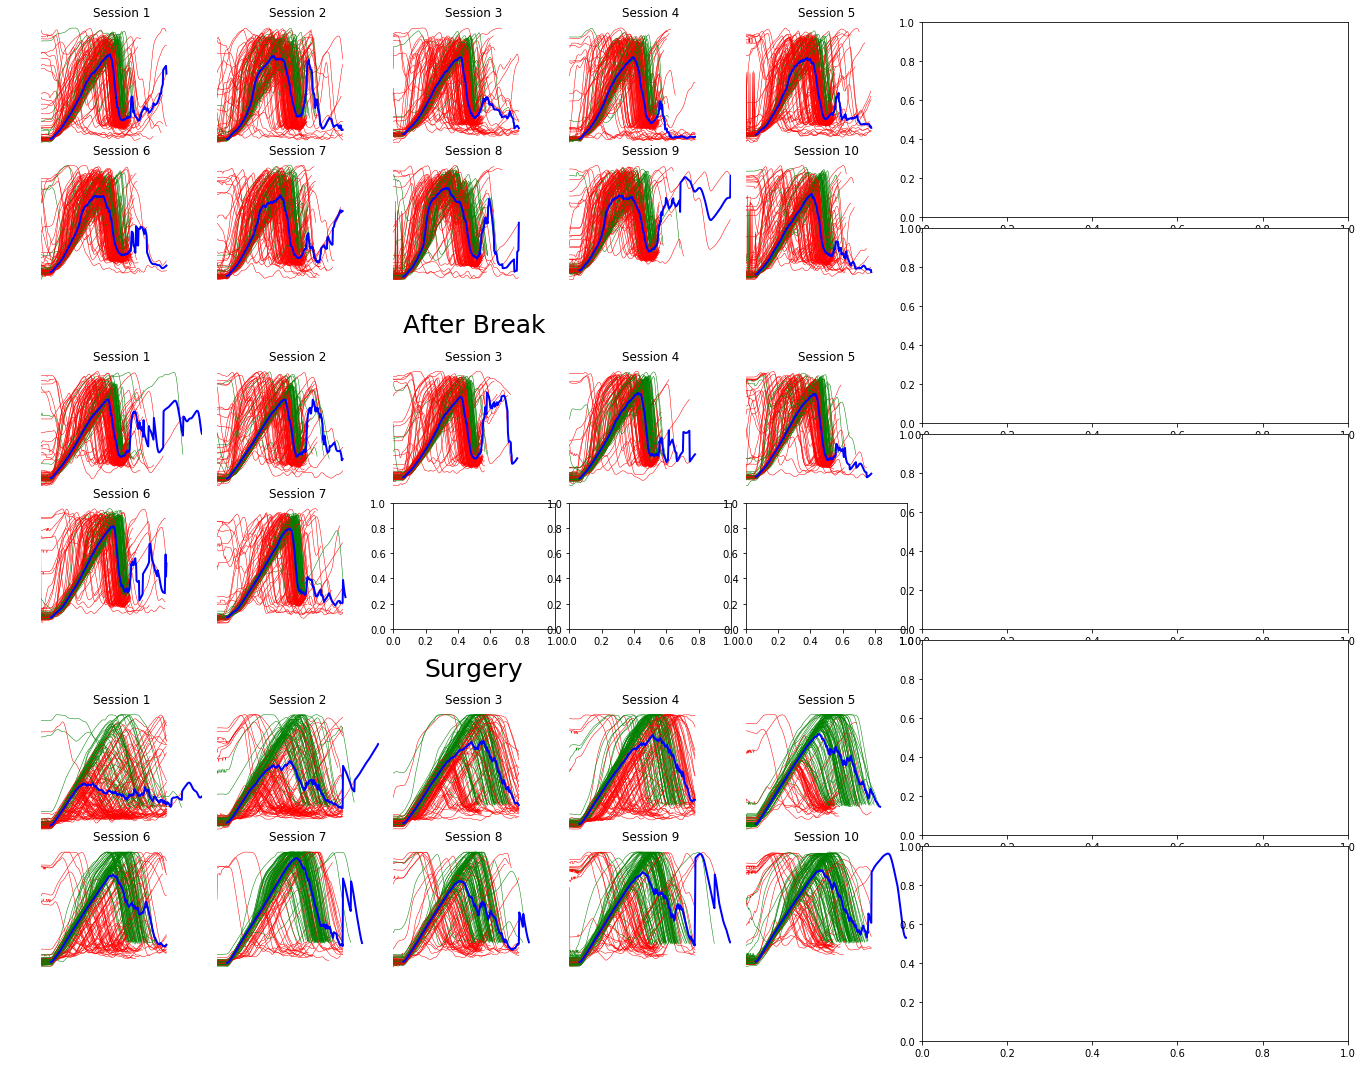

In [6]:
if "__file__" not in dir():
    assert animal in list1, "Bad animal name!"
    assert len(TaskParamToPlot)<=5, "Too many params to plot!"
    
    fig=plt.figure(figsize=figsize,tight_layout=False);

    # plotting the AllTrajectories before break
    axes=[]
    for row in range(rowNb):
        for col in range(columnNb):
            axes.append(plt.subplot2grid(shape=(gridX, gridY), loc=(row*2,col*2), colspan=2, rowspan=2))
    plot_batch_traj(root='/data', axes=axes, columnNb=columnNb, animal=animal, profile=profile1,sessionNb=-sessionNb)
 
    # writing the afterbreak text
    ax=plt.subplot2grid(shape=(gridX, gridY), loc=(4,0), colspan=10, rowspan=1)
    ax.text(x=.5,y=.5,s='After Break',verticalalignment='center', horizontalalignment='center',fontsize=25)
    ax.set_axis_off()
    
    # plotting the AllTrajectories after break
    axes=[]
    for row in range(rowNb):
        for col in range(columnNb):
            axes.append(plt.subplot2grid(shape=(gridX, gridY), loc=((row*2)+5,col*2), colspan=2, rowspan=2))
    try:
        plot_batch_traj(root='/data', axes=axes, columnNb=columnNb, animal=animal, profile=profile2,sessionNb=sessionNbAfterBreak)
    except Exception as e:
        print(repr(e))

    # writing the afterbreak text
    ax=plt.subplot2grid(shape=(gridX, gridY), loc=(9,0), colspan=10, rowspan=1)
    ax.text(x=.5,y=.5,s='Surgery',verticalalignment='center', horizontalalignment='center',fontsize=25)
    ax.set_axis_off()

    # plotting the AllTrajectories after surgery
    axes=[]
    for row in range(rowNb):
        for col in range(columnNb):
            axes.append(plt.subplot2grid(shape=(gridX, gridY), loc=((row*2)+10,col*2), colspan=2, rowspan=2))
    plot_batch_traj(root='/data', axes=axes, columnNb=columnNb, animal=animal, profile=profile3,sessionNb=sessionNb)
     
    # plotting the histo
    thisRoot="/NAS02"
    all_animals=[os.path.basename(path) for path in sorted(glob.glob(os.path.join(thisRoot,"Rat???")))]
    assert all_animals, 'NAS02 not mounted!'
    
    animalNasPath=os.path.join(thisRoot, animal, 'Histology')
    if not histoFileName:
        imageFiles=find_file(animalNasPath, extension=histoFileType)
    else:
        imageFiles=[os.path.join(animalNasPath, file) for file in histoFileName]
        
    for i in range(min([columnNb,len(imageFiles)])):
        ax=plt.subplot2grid(shape=(gridX, gridY), loc=(14,i*2), colspan=2, rowspan=2)
        ax.imshow(scipy.ndimage.imread(imageFiles[i]))
        ax.set_title(os.path.basename(imageFiles[i]))
        ax.set_axis_off()
                           
    #plotting the compare groups
    axes=[]
    for i in range(len(TaskParamToPlot)):
        axes.append(plt.subplot2grid(shape=(gridX, gridY), loc=(i*3,10), colspan=5, rowspan=3))
    
    allResults,_,_,nSessionMaxPre=plot_groups(root,groups,axes=axes,parameter=param,  
                                              redo=False,session_range=(pre_sessions,post_sessions),
                                              TaskParamToPlot=TaskParamToPlot,fullLegend=fullLegend)
    for i,ax in enumerate(axes):
        xaxis=np.arange(-abs(pre_sessions),post_sessions,1)
        data=allResults[TaskParamToPlot[i]]['group1'][animal][nSessionMaxPre['group1']+xaxis[0]:nSessionMaxPre['group1']+xaxis[-1]+1]
        ax.plot(xaxis,data,'s-',color='g',linewidth=3,markersize=9,label=animal)
    
    #drawing the legend
    l=[]
    for label in ax.get_legend_handles_labels()[1]:
        if len(label)>MaxLabelLength:
            l.append(label[:MaxLabelLength]+"...")
        else:
            l.append(label)        
    ax.legend(ax.get_legend_handles_labels()[0],l,bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

    fig.tight_layout()
    fig.suptitle(animal,y=1.02,fontsize=15)
    
#     #saving the final pdf file
#     pdf = matplotlib.backends.backend_pdf.PdfPages("/home/david/Documents/{}.pdf".format(animal))
#     pdf.savefig(fig, bbox_inches='tight')
#     pdf.close()